In [1]:
import zipfile
import os

zip_file = "/mnt/sda1/shuof/DL/HW1/spring-2025-semester-deep-learning-hw-1.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/mnt/sda1/shuof/DL/HW1/data")

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision.models import ResNet50_Weights
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 資料前處理

### Transform 設定
- Training 用的 train_transform 加入比較多 data augmentation，以提升模型的泛化能力、避免 overfitting，提升魯棒性
- Validation 跟 testing 用的 test_transform 只做 Resize 跟 Normalize

In [2]:
data_dir = './data/trainingdata'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

#### 資料切分
- 使用 `train_test_split` 將資料集以 8:2 比例切分為 training set 跟 validation set。
- 使用 `stratify` 確保各類別在 training 跟 validation set 中的比例分佈一致。

In [3]:
# 自定義的資料集類別
class FilenameLabelDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.img_paths = []
        self.labels = []
        self.transform = transform

        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)

            for fname in os.listdir(folder_path):   # 儲存圖片的完整路徑和對應的 label
                if fname.endswith('.jpg'):
                    label = int(fname.split('_')[0])
                    self.img_paths.append(os.path.join(folder_path, fname))
                    self.labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [4]:
full_dataset = FilenameLabelDataset('./data/trainingdata')

indices = list(range(len(full_dataset)))
train_idx, valid_idx = train_test_split(
    indices, test_size=0.2, stratify=full_dataset.labels, random_state=42
)

class SubsetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.dataset[self.indices[i]]
        if self.transform:
            img = self.transform(img)
        return img, label

### DataLoader 設定

In [5]:
batch_size = 64

train_dataset = SubsetWithTransform(full_dataset, train_idx, train_transform)
valid_dataset = SubsetWithTransform(full_dataset, valid_idx, test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [6]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]

test_dataset = TestDataset('./data/testingdata', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 確認標籤正確

In [7]:
from collections import defaultdict, Counter
import os

train_labels = [train_dataset.dataset[i][1] for i in train_idx]
valid_labels = [valid_dataset.dataset[i][1] for i in valid_idx]

print("Train:", Counter(train_labels))
print("Valid:", Counter(valid_labels))

Train: Counter({2: 1200, 9: 1200, 5: 1060, 0: 795, 3: 789, 8: 684, 4: 678, 10: 567, 6: 352, 1: 343, 7: 224})
Valid: Counter({9: 300, 2: 300, 5: 265, 0: 199, 3: 197, 8: 171, 4: 170, 10: 142, 6: 88, 1: 86, 7: 56})


In [8]:
folder_label_map = defaultdict(list)

for path, label in zip(full_dataset.img_paths, full_dataset.labels):
    folder_name = os.path.basename(os.path.dirname(path))  # 取出如 trainingdata0
    folder_label_map[folder_name].append(label)

total_counter = Counter()

for folder in sorted(folder_label_map.keys()):
    label_counts = Counter(folder_label_map[folder])
    print(f"{folder}: {label_counts}")
    total_counter.update(label_counts)

num_classes = 11
class_counts = np.array([total_counter[i] for i in range(num_classes)])
print("class_counts:", class_counts)

trainingdata0: Counter({0: 994})
trainingdata1: Counter({1: 429})
trainingdata10: Counter({10: 709})
trainingdata2: Counter({2: 1500})
trainingdata3: Counter({3: 986})
trainingdata4: Counter({4: 848})
trainingdata5: Counter({5: 1325})
trainingdata6: Counter({6: 440})
trainingdata7: Counter({7: 280})
trainingdata8: Counter({8: 855})
trainingdata9: Counter({9: 1500})
class_counts: [ 994  429 1500  986  848 1325  440  280  855 1500  709]


## 查看 batch 內容

In [9]:
def inverse_normalize(img_norm, mean, std):

    # Convert mean and std to tensors with the right shape for broadcasting
    mean = torch.tensor(mean, device=img_norm.device).view(1, -1, 1, 1)
    std = torch.tensor(std, device=img_norm.device).view(1, -1, 1, 1)

    # (x-mean)/std = img
    # x = img*std + mean
    # Apply inverse normalization
    return img_norm * std + mean

def imshow(img):
    # img = inverse_normalize(img, mean, std)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([64, 3, 224, 224])


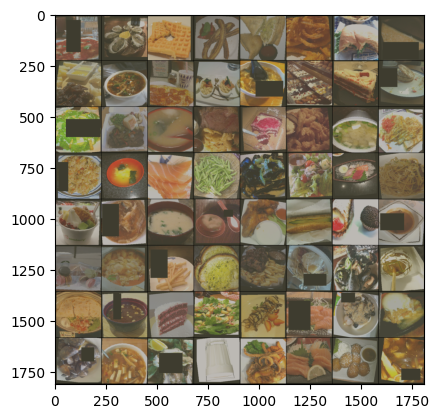

In [10]:
from torchvision.utils import make_grid

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
image_grid = make_grid(inverse_normalize(images, mean, std))

imshow(image_grid)

## 模型設計

In [18]:
# 設定

best_acc = 0
patience = 15
counter = 0
best_model_path = 'best_model.pt'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wwight
beta = 0.999

In [12]:
def compute_dynamic_weights(class_counts, beta=0.999):
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float).to(device)

In [13]:
# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        scale = self.se(x)
        return x * scale

# ResNet Bottleneck Block with SE
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.se = SEBlock(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet50 with SE blocks
class ResNet50SE(nn.Module):
    def __init__(self, num_classes=11):
        super(ResNet50SE, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 配置：ResNet50 = [3, 4, 6, 3]
        self.layer1 = self._make_layer(Bottleneck, 64,  3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [14]:
def compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5, num_classes=11):
    eps = 1e-6
    avg_val_losses = np.array([
        class_val_losses[c] / class_val_counts[c] if class_val_counts[c] > 0 else 0.0
        for c in range(num_classes)
    ])

    loss_weights = avg_val_losses / (np.sum(avg_val_losses) + eps)
    count_weights = 1.0 / (class_counts + eps)
    count_weights = count_weights / np.sum(count_weights)

    final_weights = alpha * loss_weights + (1 - alpha) * count_weights
    final_weights = final_weights / np.sum(final_weights) * num_classes

    return torch.tensor(final_weights, dtype=torch.float)

alpha = 0.5

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # class weights，Tensor of shape [num_classes]
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)  # pt = softmax prob of the correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss  # (for per-sample loss)

## 模型訓練與預測

其他測試過效果沒那麼好的

#criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
#optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
# 儲存訓練過程的數據
train_losses = []
train_accuracies = []
val_accuracies = []

model = ResNet50SE(num_classes=11).to(device)
model.fc = nn.Linear(model.fc.in_features, 11)
model = model.to(device)

weights = compute_dynamic_weights(class_counts)

# ----- Loss, Optimizer, Scheduler -----
criterion = FocalLoss(alpha=weights, gamma=2.0, reduction='none') 
#criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

# ----- training loop -----
for epoch in range(200):
    model.train()
    
    total_loss = 0
    correct_train, total_train = 0, 0
    class_loss_sum = defaultdict(float)
    class_sample_count = defaultdict(int)

    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)
        per_sample_loss = criterion(outputs, labels)
        loss = per_sample_loss.mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_loss_sum[label] += per_sample_loss[i].item()
            class_sample_count[label] += 1

    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")
    
    # ----- validation -----
    model.eval()
    correct, total = 0, 0
    class_val_losses = [0.0 for _ in range(11)]
    class_val_counts = [0 for _ in range(11)]

    val_bar = tqdm(valid_loader, desc=f"[Valid] Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss = F.cross_entropy(outputs, labels, reduction='none')

            for i in range(len(labels)):
                cls = labels[i].item()
                class_val_losses[cls] += val_loss[i].item()
                class_val_counts[cls] += 1

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Training Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}")

    # 每10 epoch 顯示類別 loss 和動態調整 class weiights
    if epoch % 10 == 0:
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")
        print("[Per-class Training Loss]")
        for c in range(11):
            if class_sample_count[c] > 0:
                avg = class_loss_sum[c] / class_sample_count[c]
                print(f"  Class {c}: Avg Train Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        print("[Per-class Validation Loss]")
        for c in range(11):
            if class_val_counts[c] > 0:
                avg = class_val_losses[c] / class_val_counts[c]
                print(f"  Class {c}: Avg Val Loss = {avg:.4f}")
            else:
                print(f"  Class {c}: No samples")

        # 動態調整 class weights
        weights = compute_dynamic_loss_weights(class_val_losses, class_val_counts, class_counts, alpha=0.5).to(device)
        criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1, reduction='none')
        print(f"Updated class weights at epoch {epoch+1}: {weights.cpu().numpy()}")

    # Early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("=== Accuracy improved, model saved. ===")
    else:
        counter += 1
        print(f"=== No improvement for {counter} epochs. ===")

    if counter >= patience:
        print("=== Early stopping triggered. ===")
        break

    scheduler.step()


Epoch 1 | Training Loss: 1.4176


Training Accuracy: 0.2200 | Validation Accuracy: 0.2325
Current LR: 0.001000
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.3141
  Class 1: Avg Train Loss = 3.0465
  Class 2: Avg Train Loss = 0.8064
  Class 3: Avg Train Loss = 1.3633
  Class 4: Avg Train Loss = 1.4381
  Class 5: Avg Train Loss = 0.8783
  Class 6: Avg Train Loss = 3.2022
  Class 7: Avg Train Loss = 5.3920
  Class 8: Avg Train Loss = 1.5755
  Class 9: Avg Train Loss = 0.7671
  Class 10: Avg Train Loss = 1.4706
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.1912
  Class 1: Avg Val Loss = 2.1384
  Class 2: Avg Val Loss = 2.2405
  Class 3: Avg Val Loss = 2.4325
  Class 4: Avg Val Loss = 1.9433
  Class 5: Avg Val Loss = 2.5450
  Class 6: Avg Val Loss = 2.5470
  Class 7: Avg Val Loss = 2.5437
  Class 8: Avg Val Loss = 2.3749
  Class 9: Avg Val Loss = 1.8221
  Class 10: Avg Val Loss = 1.9834
Updated class weights at epoch 1: [0.8315936  1.274125   0.72619325 0.8879887  0.8359302  0.82402223
 1.3449037  1.7894


Epoch 2 | Training Loss: 2.0407


Training Accuracy: 0.2282 | Validation Accuracy: 0.1950
=== No improvement for 1 epochs. ===



Epoch 3 | Training Loss: 1.8684


Training Accuracy: 0.3082 | Validation Accuracy: 0.3511
=== Accuracy improved, model saved. ===



Epoch 4 | Training Loss: 1.7820


Training Accuracy: 0.3540 | Validation Accuracy: 0.3556
=== Accuracy improved, model saved. ===



Epoch 5 | Training Loss: 1.7201


Training Accuracy: 0.3825 | Validation Accuracy: 0.3951
=== Accuracy improved, model saved. ===



Epoch 6 | Training Loss: 1.6589


Training Accuracy: 0.4207 | Validation Accuracy: 0.4159
=== Accuracy improved, model saved. ===



Epoch 7 | Training Loss: 1.6203


Training Accuracy: 0.4278 | Validation Accuracy: 0.4124
=== No improvement for 1 epochs. ===



Epoch 8 | Training Loss: 1.6039


Training Accuracy: 0.4418 | Validation Accuracy: 0.4336
=== Accuracy improved, model saved. ===



Epoch 9 | Training Loss: 1.5619


Training Accuracy: 0.4669 | Validation Accuracy: 0.4428
=== Accuracy improved, model saved. ===



Epoch 10 | Training Loss: 1.5227


Training Accuracy: 0.4812 | Validation Accuracy: 0.4032
=== No improvement for 1 epochs. ===



Epoch 11 | Training Loss: 1.4937


Training Accuracy: 0.5011 | Validation Accuracy: 0.4569
Current LR: 0.000976
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.7126
  Class 1: Avg Train Loss = 2.2819
  Class 2: Avg Train Loss = 1.3696
  Class 3: Avg Train Loss = 1.5572
  Class 4: Avg Train Loss = 1.5461
  Class 5: Avg Train Loss = 1.2645
  Class 6: Avg Train Loss = 1.9623
  Class 7: Avg Train Loss = 2.9288
  Class 8: Avg Train Loss = 1.4635
  Class 9: Avg Train Loss = 1.1342
  Class 10: Avg Train Loss = 1.1914
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 2.1294
  Class 1: Avg Val Loss = 1.5852
  Class 2: Avg Val Loss = 1.9562
  Class 3: Avg Val Loss = 1.5468
  Class 4: Avg Val Loss = 1.7844
  Class 5: Avg Val Loss = 1.1405
  Class 6: Avg Val Loss = 2.0870
  Class 7: Avg Val Loss = 1.3313
  Class 8: Avg Val Loss = 0.7758
  Class 9: Avg Val Loss = 1.4211
  Class 10: Avg Val Loss = 1.8747
Updated class weights at epoch 11: [1.0091236  1.2936205  0.8387452  0.83018106 0.9608748  0.6145079
 1.4301606  1.6396


Epoch 12 | Training Loss: 1.4741


Training Accuracy: 0.5199 | Validation Accuracy: 0.4676
=== Accuracy improved, model saved. ===



Epoch 13 | Training Loss: 1.4479


Training Accuracy: 0.5398 | Validation Accuracy: 0.4873
=== Accuracy improved, model saved. ===



Epoch 14 | Training Loss: 1.4147


Training Accuracy: 0.5488 | Validation Accuracy: 0.4833
=== No improvement for 1 epochs. ===



Epoch 15 | Training Loss: 1.4040


Training Accuracy: 0.5577 | Validation Accuracy: 0.5405
=== Accuracy improved, model saved. ===



Epoch 16 | Training Loss: 1.3719


Training Accuracy: 0.5782 | Validation Accuracy: 0.5025
=== No improvement for 1 epochs. ===



Epoch 17 | Training Loss: 1.3510


Training Accuracy: 0.5822 | Validation Accuracy: 0.5496
=== Accuracy improved, model saved. ===



Epoch 18 | Training Loss: 1.3393


Training Accuracy: 0.5827 | Validation Accuracy: 0.5041
=== No improvement for 1 epochs. ===



Epoch 19 | Training Loss: 1.3130


Training Accuracy: 0.6044 | Validation Accuracy: 0.5638
=== Accuracy improved, model saved. ===



Epoch 20 | Training Loss: 1.2974


Training Accuracy: 0.6138 | Validation Accuracy: 0.5856
=== Accuracy improved, model saved. ===



Epoch 21 | Training Loss: 1.2564


Training Accuracy: 0.6287 | Validation Accuracy: 0.5643
Current LR: 0.000905
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.5978
  Class 1: Avg Train Loss = 1.8655
  Class 2: Avg Train Loss = 1.2592
  Class 3: Avg Train Loss = 1.3234
  Class 4: Avg Train Loss = 1.4070
  Class 5: Avg Train Loss = 0.9650
  Class 6: Avg Train Loss = 1.5263
  Class 7: Avg Train Loss = 2.0515
  Class 8: Avg Train Loss = 1.1082
  Class 9: Avg Train Loss = 0.9607
  Class 10: Avg Train Loss = 1.0173
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.4857
  Class 1: Avg Val Loss = 1.4793
  Class 2: Avg Val Loss = 1.4526
  Class 3: Avg Val Loss = 0.7653
  Class 4: Avg Val Loss = 1.5777
  Class 5: Avg Val Loss = 1.1476
  Class 6: Avg Val Loss = 1.4353
  Class 7: Avg Val Loss = 1.2199
  Class 8: Avg Val Loss = 1.2306
  Class 9: Avg Val Loss = 1.5484
  Class 10: Avg Val Loss = 0.6263
Updated class weights at epoch 21: [0.92986345 1.3816046  0.8005     0.6490117  1.0255055  0.7105929
 1.3443207  1.7047


Epoch 22 | Training Loss: 1.2654


Training Accuracy: 0.6338 | Validation Accuracy: 0.6211
=== Accuracy improved, model saved. ===



Epoch 23 | Training Loss: 1.2625


Training Accuracy: 0.6341 | Validation Accuracy: 0.5912
=== No improvement for 1 epochs. ===



Epoch 24 | Training Loss: 1.2529


Training Accuracy: 0.6329 | Validation Accuracy: 0.6069
=== No improvement for 2 epochs. ===



Epoch 25 | Training Loss: 1.2335


Training Accuracy: 0.6481 | Validation Accuracy: 0.5522
=== No improvement for 3 epochs. ===



Epoch 26 | Training Loss: 1.2077


Training Accuracy: 0.6622 | Validation Accuracy: 0.5507
=== No improvement for 4 epochs. ===



Epoch 27 | Training Loss: 1.1848


Training Accuracy: 0.6733 | Validation Accuracy: 0.5370
=== No improvement for 5 epochs. ===



Epoch 28 | Training Loss: 1.1789


Training Accuracy: 0.6789 | Validation Accuracy: 0.6373
=== Accuracy improved, model saved. ===



Epoch 29 | Training Loss: 1.1538


Training Accuracy: 0.6846 | Validation Accuracy: 0.5623
=== No improvement for 1 epochs. ===



Epoch 30 | Training Loss: 1.1353


Training Accuracy: 0.6948 | Validation Accuracy: 0.5745
=== No improvement for 2 epochs. ===



Epoch 31 | Training Loss: 1.1164


Training Accuracy: 0.7025 | Validation Accuracy: 0.6013
Current LR: 0.000796
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.3660
  Class 1: Avg Train Loss = 1.5298
  Class 2: Avg Train Loss = 1.1756
  Class 3: Avg Train Loss = 1.1193
  Class 4: Avg Train Loss = 1.2229
  Class 5: Avg Train Loss = 0.9519
  Class 6: Avg Train Loss = 1.2218
  Class 7: Avg Train Loss = 1.5668
  Class 8: Avg Train Loss = 1.0691
  Class 9: Avg Train Loss = 0.9078
  Class 10: Avg Train Loss = 0.8276
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.1754
  Class 1: Avg Val Loss = 0.9990
  Class 2: Avg Val Loss = 1.7265
  Class 3: Avg Val Loss = 1.7146
  Class 4: Avg Val Loss = 1.9617
  Class 5: Avg Val Loss = 0.8570
  Class 6: Avg Val Loss = 1.4748
  Class 7: Avg Val Loss = 0.5414
  Class 8: Avg Val Loss = 0.8171
  Class 9: Avg Val Loss = 0.6930
  Class 10: Avg Val Loss = 0.3295
Updated class weights at epoch 31: [0.87093604 1.246241   1.001196   1.1150032  1.282193   0.6422862
 1.4391551  1.4667


Epoch 32 | Training Loss: 1.1535


Training Accuracy: 0.6932 | Validation Accuracy: 0.6322
=== No improvement for 4 epochs. ===



Epoch 33 | Training Loss: 1.1280


Training Accuracy: 0.7017 | Validation Accuracy: 0.6201
=== No improvement for 5 epochs. ===



Epoch 34 | Training Loss: 1.1078


Training Accuracy: 0.7087 | Validation Accuracy: 0.6054
=== No improvement for 6 epochs. ===



Epoch 35 | Training Loss: 1.0961


Training Accuracy: 0.7172 | Validation Accuracy: 0.6682
=== Accuracy improved, model saved. ===



Epoch 36 | Training Loss: 1.0837


Training Accuracy: 0.7257 | Validation Accuracy: 0.6444
=== No improvement for 1 epochs. ===



Epoch 37 | Training Loss: 1.0630


Training Accuracy: 0.7350 | Validation Accuracy: 0.6429
=== No improvement for 2 epochs. ===



Epoch 38 | Training Loss: 1.0513


Training Accuracy: 0.7456 | Validation Accuracy: 0.6499
=== No improvement for 3 epochs. ===



Epoch 39 | Training Loss: 1.0278


Training Accuracy: 0.7515 | Validation Accuracy: 0.6494
=== No improvement for 4 epochs. ===



Epoch 40 | Training Loss: 1.0188


Training Accuracy: 0.7585 | Validation Accuracy: 0.6819
=== Accuracy improved, model saved. ===



Epoch 41 | Training Loss: 1.0217


Training Accuracy: 0.7547 | Validation Accuracy: 0.7097
Current LR: 0.000658
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.2467
  Class 1: Avg Train Loss = 1.3418
  Class 2: Avg Train Loss = 1.1271
  Class 3: Avg Train Loss = 1.1599
  Class 4: Avg Train Loss = 1.1907
  Class 5: Avg Train Loss = 0.8740
  Class 6: Avg Train Loss = 1.0437
  Class 7: Avg Train Loss = 1.2416
  Class 8: Avg Train Loss = 0.9359
  Class 9: Avg Train Loss = 0.7439
  Class 10: Avg Train Loss = 0.7502
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.6138
  Class 1: Avg Val Loss = 1.1335
  Class 2: Avg Val Loss = 0.8488
  Class 3: Avg Val Loss = 1.0679
  Class 4: Avg Val Loss = 0.8111
  Class 5: Avg Val Loss = 1.0123
  Class 6: Avg Val Loss = 0.6541
  Class 7: Avg Val Loss = 0.8173
  Class 8: Avg Val Loss = 0.7769
  Class 9: Avg Val Loss = 0.5874
  Class 10: Avg Val Loss = 0.6292
Updated class weights at epoch 41: [1.2367492  1.4255848  0.69764525 0.93786794 0.8525257  0.8181617
 1.1406631  1.6760


Epoch 42 | Training Loss: 0.9826


Training Accuracy: 0.7741 | Validation Accuracy: 0.6292
=== No improvement for 1 epochs. ===



Epoch 43 | Training Loss: 0.9717


Training Accuracy: 0.7779 | Validation Accuracy: 0.6955
=== No improvement for 2 epochs. ===



Epoch 44 | Training Loss: 0.9693


Training Accuracy: 0.7762 | Validation Accuracy: 0.7178
=== Accuracy improved, model saved. ===



Epoch 45 | Training Loss: 0.9425


Training Accuracy: 0.7916 | Validation Accuracy: 0.7107
=== No improvement for 1 epochs. ===



Epoch 46 | Training Loss: 0.9302


Training Accuracy: 0.7998 | Validation Accuracy: 0.7072
=== No improvement for 2 epochs. ===



Epoch 47 | Training Loss: 0.9284


Training Accuracy: 0.7992 | Validation Accuracy: 0.6738
=== No improvement for 3 epochs. ===



Epoch 48 | Training Loss: 0.9076


Training Accuracy: 0.8108 | Validation Accuracy: 0.7366
=== Accuracy improved, model saved. ===



Epoch 49 | Training Loss: 0.9002


Training Accuracy: 0.8112 | Validation Accuracy: 0.7128
=== No improvement for 1 epochs. ===



Epoch 50 | Training Loss: 0.8883


Training Accuracy: 0.8212 | Validation Accuracy: 0.7183
=== No improvement for 2 epochs. ===



Epoch 51 | Training Loss: 0.8719


Training Accuracy: 0.8259 | Validation Accuracy: 0.7285
Current LR: 0.000505
[Per-class Training Loss]
  Class 0: Avg Train Loss = 1.1048
  Class 1: Avg Train Loss = 1.1014
  Class 2: Avg Train Loss = 0.9094
  Class 3: Avg Train Loss = 0.9493
  Class 4: Avg Train Loss = 0.9506
  Class 5: Avg Train Loss = 0.8229
  Class 6: Avg Train Loss = 0.7731
  Class 7: Avg Train Loss = 0.9636
  Class 8: Avg Train Loss = 0.8433
  Class 9: Avg Train Loss = 0.6769
  Class 10: Avg Train Loss = 0.6906
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.1807
  Class 1: Avg Val Loss = 1.1847
  Class 2: Avg Val Loss = 0.8903
  Class 3: Avg Val Loss = 1.1522
  Class 4: Avg Val Loss = 1.3303
  Class 5: Avg Val Loss = 0.8274
  Class 6: Avg Val Loss = 0.3317
  Class 7: Avg Val Loss = 0.6463
  Class 8: Avg Val Loss = 0.7769
  Class 9: Avg Val Loss = 0.4767
  Class 10: Avg Val Loss = 0.7485
Updated class weights at epoch 51: [1.0252087  1.4817159  0.74151415 1.011553   1.1707721  0.73546004
 0.9703077  1.596


Epoch 52 | Training Loss: 0.8623


Training Accuracy: 0.8321 | Validation Accuracy: 0.6586
=== No improvement for 4 epochs. ===



Epoch 53 | Training Loss: 0.8507


Training Accuracy: 0.8410 | Validation Accuracy: 0.7092
=== No improvement for 5 epochs. ===



Epoch 54 | Training Loss: 0.8374


Training Accuracy: 0.8454 | Validation Accuracy: 0.7204
=== No improvement for 6 epochs. ===



Epoch 55 | Training Loss: 0.8256


Training Accuracy: 0.8512 | Validation Accuracy: 0.7477
=== Accuracy improved, model saved. ===



Epoch 56 | Training Loss: 0.8167


Training Accuracy: 0.8561 | Validation Accuracy: 0.7158
=== No improvement for 1 epochs. ===



Epoch 57 | Training Loss: 0.8104


Training Accuracy: 0.8607 | Validation Accuracy: 0.7371
=== No improvement for 2 epochs. ===



Epoch 58 | Training Loss: 0.7958


Training Accuracy: 0.8683 | Validation Accuracy: 0.7224
=== No improvement for 3 epochs. ===



Epoch 59 | Training Loss: 0.7853


Training Accuracy: 0.8700 | Validation Accuracy: 0.7340
=== No improvement for 4 epochs. ===



Epoch 60 | Training Loss: 0.7777


Training Accuracy: 0.8732 | Validation Accuracy: 0.7254
=== No improvement for 5 epochs. ===



Epoch 61 | Training Loss: 0.7687


Training Accuracy: 0.8767 | Validation Accuracy: 0.7391
Current LR: 0.000352
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.9115
  Class 1: Avg Train Loss = 0.9099
  Class 2: Avg Train Loss = 0.8062
  Class 3: Avg Train Loss = 0.8531
  Class 4: Avg Train Loss = 0.8705
  Class 5: Avg Train Loss = 0.7375
  Class 6: Avg Train Loss = 0.6781
  Class 7: Avg Train Loss = 0.7806
  Class 8: Avg Train Loss = 0.7267
  Class 9: Avg Train Loss = 0.6172
  Class 10: Avg Train Loss = 0.6540
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.4091
  Class 1: Avg Val Loss = 0.9480
  Class 2: Avg Val Loss = 1.2984
  Class 3: Avg Val Loss = 0.6898
  Class 4: Avg Val Loss = 0.5150
  Class 5: Avg Val Loss = 0.5436
  Class 6: Avg Val Loss = 0.3016
  Class 7: Avg Val Loss = 0.7047
  Class 8: Avg Val Loss = 0.7752
  Class 9: Avg Val Loss = 1.0533
  Class 10: Avg Val Loss = 0.4501
Updated class weights at epoch 61: [1.236867   1.3992233  1.050431   0.7843267  0.7302706  0.60284287
 0.970074   1.670


Epoch 62 | Training Loss: 0.7723


Training Accuracy: 0.8862 | Validation Accuracy: 0.7396
=== No improvement for 7 epochs. ===



Epoch 63 | Training Loss: 0.7627


Training Accuracy: 0.8882 | Validation Accuracy: 0.7447
=== No improvement for 8 epochs. ===



Epoch 64 | Training Loss: 0.7553


Training Accuracy: 0.8924 | Validation Accuracy: 0.7528
=== Accuracy improved, model saved. ===



Epoch 65 | Training Loss: 0.7362


Training Accuracy: 0.9027 | Validation Accuracy: 0.7462
=== No improvement for 1 epochs. ===



Epoch 66 | Training Loss: 0.7321


Training Accuracy: 0.9031 | Validation Accuracy: 0.7634
=== Accuracy improved, model saved. ===



Epoch 67 | Training Loss: 0.7180


Training Accuracy: 0.9099 | Validation Accuracy: 0.7513
=== No improvement for 1 epochs. ===



Epoch 68 | Training Loss: 0.7079


Training Accuracy: 0.9151 | Validation Accuracy: 0.7477
=== No improvement for 2 epochs. ===



Epoch 69 | Training Loss: 0.7036


Training Accuracy: 0.9195 | Validation Accuracy: 0.7609
=== No improvement for 3 epochs. ===



Epoch 70 | Training Loss: 0.6879


Training Accuracy: 0.9245 | Validation Accuracy: 0.7553
=== No improvement for 4 epochs. ===



Epoch 71 | Training Loss: 0.6765


Training Accuracy: 0.9340 | Validation Accuracy: 0.7558
Current LR: 0.000214
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.7590
  Class 1: Avg Train Loss = 0.7748
  Class 2: Avg Train Loss = 0.7213
  Class 3: Avg Train Loss = 0.7038
  Class 4: Avg Train Loss = 0.6915
  Class 5: Avg Train Loss = 0.6291
  Class 6: Avg Train Loss = 0.6123
  Class 7: Avg Train Loss = 0.6725
  Class 8: Avg Train Loss = 0.6673
  Class 9: Avg Train Loss = 0.6238
  Class 10: Avg Train Loss = 0.5839
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.2522
  Class 1: Avg Val Loss = 1.4094
  Class 2: Avg Val Loss = 0.7988
  Class 3: Avg Val Loss = 0.6584
  Class 4: Avg Val Loss = 1.0980
  Class 5: Avg Val Loss = 1.0541
  Class 6: Avg Val Loss = 0.3364
  Class 7: Avg Val Loss = 0.6847
  Class 8: Avg Val Loss = 0.6262
  Class 9: Avg Val Loss = 0.6333
  Class 10: Avg Val Loss = 0.4335
Updated class weights at epoch 71: [1.1114314  1.6618521  0.7175321  0.7507409  1.0763874  0.90400946
 0.9850879  1.643


Epoch 72 | Training Loss: 0.6664


Training Accuracy: 0.9320 | Validation Accuracy: 0.7690
=== Accuracy improved, model saved. ===



Epoch 73 | Training Loss: 0.6590


Training Accuracy: 0.9358 | Validation Accuracy: 0.7614
=== No improvement for 1 epochs. ===



Epoch 74 | Training Loss: 0.6595


Training Accuracy: 0.9361 | Validation Accuracy: 0.7644
=== No improvement for 2 epochs. ===



Epoch 75 | Training Loss: 0.6493


Training Accuracy: 0.9413 | Validation Accuracy: 0.7675
=== No improvement for 3 epochs. ===



Epoch 76 | Training Loss: 0.6365


Training Accuracy: 0.9488 | Validation Accuracy: 0.7644
=== No improvement for 4 epochs. ===



Epoch 77 | Training Loss: 0.6287


Training Accuracy: 0.9521 | Validation Accuracy: 0.7634
=== No improvement for 5 epochs. ===



Epoch 78 | Training Loss: 0.6334


Training Accuracy: 0.9487 | Validation Accuracy: 0.7695
=== Accuracy improved, model saved. ===



Epoch 79 | Training Loss: 0.6239


Training Accuracy: 0.9515 | Validation Accuracy: 0.7776
=== Accuracy improved, model saved. ===



Epoch 80 | Training Loss: 0.6139


Training Accuracy: 0.9602 | Validation Accuracy: 0.7741
=== No improvement for 1 epochs. ===



Epoch 81 | Training Loss: 0.6186


Training Accuracy: 0.9584 | Validation Accuracy: 0.7857
Current LR: 0.000105
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.6574
  Class 1: Avg Train Loss = 0.7159
  Class 2: Avg Train Loss = 0.6225
  Class 3: Avg Train Loss = 0.6228
  Class 4: Avg Train Loss = 0.6767
  Class 5: Avg Train Loss = 0.6510
  Class 6: Avg Train Loss = 0.5781
  Class 7: Avg Train Loss = 0.6494
  Class 8: Avg Train Loss = 0.5985
  Class 9: Avg Train Loss = 0.5462
  Class 10: Avg Train Loss = 0.5507
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.4584
  Class 1: Avg Val Loss = 1.0185
  Class 2: Avg Val Loss = 1.1741
  Class 3: Avg Val Loss = 0.6699
  Class 4: Avg Val Loss = 0.6907
  Class 5: Avg Val Loss = 0.6684
  Class 6: Avg Val Loss = 0.3007
  Class 7: Avg Val Loss = 0.4478
  Class 8: Avg Val Loss = 0.6125
  Class 9: Avg Val Loss = 0.5305
  Class 10: Avg Val Loss = 0.4358
Updated class weights at epoch 81: [1.3466483  1.4987162  1.0349813  0.8078298  0.87870556 0.7178622
 0.98570544 1.5319


Epoch 82 | Training Loss: 0.6174


Training Accuracy: 0.9608 | Validation Accuracy: 0.7766
=== No improvement for 1 epochs. ===



Epoch 83 | Training Loss: 0.6114


Training Accuracy: 0.9619 | Validation Accuracy: 0.7700
=== No improvement for 2 epochs. ===



Epoch 84 | Training Loss: 0.6122


Training Accuracy: 0.9640 | Validation Accuracy: 0.7796
=== No improvement for 3 epochs. ===



Epoch 85 | Training Loss: 0.6031


Training Accuracy: 0.9671 | Validation Accuracy: 0.7730
=== No improvement for 4 epochs. ===



Epoch 86 | Training Loss: 0.5980


Training Accuracy: 0.9692 | Validation Accuracy: 0.7771
=== No improvement for 5 epochs. ===



Epoch 87 | Training Loss: 0.6016


Training Accuracy: 0.9679 | Validation Accuracy: 0.7837
=== No improvement for 6 epochs. ===



Epoch 88 | Training Loss: 0.5914


Training Accuracy: 0.9728 | Validation Accuracy: 0.7786
=== No improvement for 7 epochs. ===



Epoch 89 | Training Loss: 0.5920


Training Accuracy: 0.9711 | Validation Accuracy: 0.7852
=== No improvement for 8 epochs. ===



Epoch 90 | Training Loss: 0.5898


Training Accuracy: 0.9710 | Validation Accuracy: 0.7761
=== No improvement for 9 epochs. ===



Epoch 91 | Training Loss: 0.5866


Training Accuracy: 0.9743 | Validation Accuracy: 0.7847
Current LR: 0.000034
[Per-class Training Loss]
  Class 0: Avg Train Loss = 0.6408
  Class 1: Avg Train Loss = 0.6154
  Class 2: Avg Train Loss = 0.6087
  Class 3: Avg Train Loss = 0.6079
  Class 4: Avg Train Loss = 0.6261
  Class 5: Avg Train Loss = 0.5609
  Class 6: Avg Train Loss = 0.5738
  Class 7: Avg Train Loss = 0.5937
  Class 8: Avg Train Loss = 0.5735
  Class 9: Avg Train Loss = 0.5299
  Class 10: Avg Train Loss = 0.5563
[Per-class Validation Loss]
  Class 0: Avg Val Loss = 1.1999
  Class 1: Avg Val Loss = 1.1056
  Class 2: Avg Val Loss = 0.9905
  Class 3: Avg Val Loss = 0.8716
  Class 4: Avg Val Loss = 0.7283
  Class 5: Avg Val Loss = 0.7888
  Class 6: Avg Val Loss = 0.3155
  Class 7: Avg Val Loss = 0.5358
  Class 8: Avg Val Loss = 0.6938
  Class 9: Avg Val Loss = 0.5251
  Class 10: Avg Val Loss = 0.3992
Updated class weights at epoch 91: [1.1542208  1.5448917  0.8966608  0.9355983  0.8955423  0.7907811
 0.9920026  1.5858


Epoch 92 | Training Loss: 0.5874


Training Accuracy: 0.9735 | Validation Accuracy: 0.7720
=== No improvement for 11 epochs. ===



Epoch 93 | Training Loss: 0.5847


Training Accuracy: 0.9755 | Validation Accuracy: 0.7786
=== No improvement for 12 epochs. ===



Epoch 94 | Training Loss: 0.5843


Training Accuracy: 0.9745 | Validation Accuracy: 0.7801
=== No improvement for 13 epochs. ===



Epoch 95 | Training Loss: 0.5832


Training Accuracy: 0.9758 | Validation Accuracy: 0.7822
=== No improvement for 14 epochs. ===



Epoch 96 | Training Loss: 0.5788


Training Accuracy: 0.9762 | Validation Accuracy: 0.7796
=== No improvement for 15 epochs. ===
=== Early stopping triggered. ===


In [20]:
model

ResNet50SE(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(256, 1

### 模型訓練過程與變化(Training Loss跟 Validation Accuracy的變化圖)

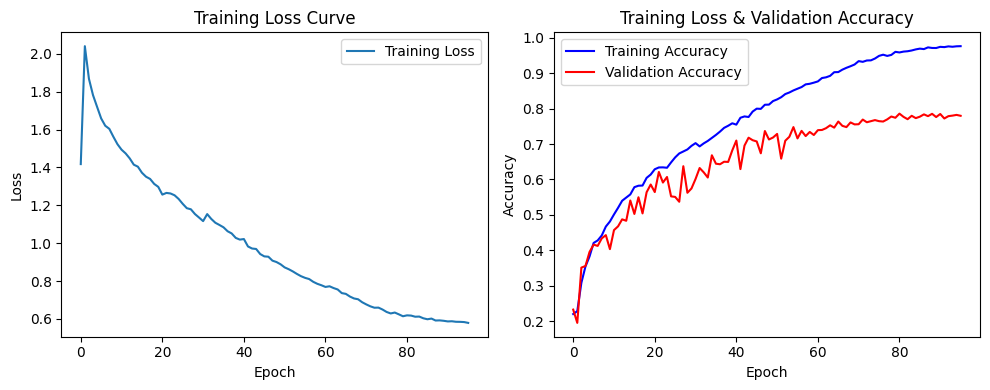

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Loss & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds = []
with torch.no_grad():
    for imgs, filenames in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        for fname, label in zip(filenames, predicted.cpu().numpy()):
            index = int(os.path.splitext(fname)[0])
            preds.append((index, label))

df = pd.DataFrame(preds, columns=['Index', 'Label'])
df = df.sort_values(by='Index')
df.to_csv('submission10_resnet50_2_2.csv', index=False)

/tmp/ipykernel_378441/519844408.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


## 其他檢查內容

### 測試單張圖片預測結果

### 查看 Layer 資訊